In [23]:
import heapq
import networkx as nx
import time
from math import ceil
import matplotlib.pyplot as plt

In [24]:
main_graph = nx.read_graphml("grafo_ponte_tocha.graphml")
main_crossing_times = {'A': 1, 'B': 2, 'C': 5, 'D': 10}

In [25]:
def parse_state(node_str: str):
    """
    Convert a node string from GraphML into a state tuple.
    Example: "inicio=ABCD|tocha=inicio" -> (frozenset({'A','B','C','D'}), 'inicio')
    """
    left, right = node_str.split("|")
    people_str = left.split("=")[1].strip()
    torch_pos = right.split("=")[1].strip()

    if people_str == "VAZIO":
        people = frozenset()
    else:
        people = frozenset(list(people_str))

    return people, torch_pos

In [26]:
def a_star(graph: nx.DiGraph, start: str, goal: str, heuristic):
    """
    A* algorithm for NetworkX graphs.
    :param graph: NetworkX graph (nx.Graph ou nx.DiGraph)
    :param start: Initial node
    :param goal: Goal node
    :param heuristic: Heuristic function h(node)
    :return: (path, total_cost) or (None, inf) if there is no solution
    """

    # frontier = priority queue of (f, g, path)
    frontier = []
    h_start = heuristic(parse_state(start))
    heapq.heappush(frontier, (h_start, 0, [start]))

    # known accumulated costs
    g_cost = {start: 0}
    explored_edges = []  # list of (u, v)
    node_values = {}      # dict[node] = {"g": ..., "h": ..., "f": ...}

    node_values[start] = {"g": 0, "h": h_start, "f": h_start}

    while frontier:
        f, g, path = heapq.heappop(frontier)
        current = path[-1]

        # check goal
        if current == goal:
            return path, g, explored_edges, node_values

        # expand neighbors
        for neighbor in graph.neighbors(current):
            # edge cost
            edge_cost = graph[current][neighbor].get("weight")
            new_g = g + edge_cost

            # salvar a aresta explorada
            explored_edges.append((current, neighbor))

            if neighbor not in g_cost or new_g < g_cost[neighbor]:
                g_cost[neighbor] = new_g
                h_val = heuristic(parse_state(neighbor))
                new_f = new_g + h_val
                node_values[neighbor] = {"g": new_g, "h": h_val, "f": new_f}
                new_path = path + [neighbor]
                heapq.heappush(frontier, (new_f, new_g, new_path))

    return None, float("inf"), explored_edges, node_values

def heuristic_func(state):
    """
    Admissible heuristic for the Bridge and Torch problem.
    :param state: (frozenset of people on the start side, torch position)
    :return: heuristic estimate of the remaining cost
    """
    people_start, _ = state
    m = len(people_start)
    if m == 0:
        return 0

    slowest = max(main_crossing_times[p] for p in people_start)
    fastest = min(main_crossing_times.values())

    needed_forward = ceil(m / 2) # minimum number of forward crossings
    min_returns = max(0, needed_forward - 1) # minimum number of returns
    estimated_returns = min_returns * fastest

    return max(slowest, estimated_returns)

In [27]:
start_time = time.time()
start_str = "inicio=ABCD|tocha=inicio"
goal_str = "inicio=VAZIO|tocha=final"

if start_str not in main_graph or goal_str not in main_graph:
    raise ValueError("Start or Goal not in graph.")

final_path, final_cost, explored_edges, node_values = a_star(graph=main_graph, start=start_str, goal=goal_str, heuristic=heuristic_func)
end_time = time.time()
duration = end_time - start_time
print(f"Caminho: {final_path}")
print(f"Custo total: {final_cost}")
print(f"Tempo de execução: {duration}")
print("\nExplored edges with node values:")
for u, v in explored_edges:
    vals = node_values.get(v, {"g": "-", "h": "-", "f": "-"})  # pega os valores do destino
    print(f"{u} -> {v} | g={vals['g']}, h={vals['h']}, f={vals['f']}")

Caminho: ['inicio=ABCD|tocha=inicio', 'inicio=CD|tocha=final', 'inicio=ACD|tocha=inicio', 'inicio=A|tocha=final', 'inicio=AB|tocha=inicio', 'inicio=VAZIO|tocha=final']
Custo total: 17
Tempo de execução: 0.0014998912811279297

Explored edges with node values:
inicio=ABCD|tocha=inicio -> inicio=AB|tocha=final | g=10, h=2, f=12
inicio=ABCD|tocha=inicio -> inicio=BC|tocha=final | g=10, h=5, f=15
inicio=ABCD|tocha=inicio -> inicio=AC|tocha=final | g=10, h=5, f=15
inicio=ABCD|tocha=inicio -> inicio=BD|tocha=final | g=5, h=10, f=15
inicio=ABCD|tocha=inicio -> inicio=AD|tocha=final | g=5, h=10, f=15
inicio=ABCD|tocha=inicio -> inicio=CD|tocha=final | g=2, h=10, f=12
inicio=CD|tocha=final -> inicio=ACD|tocha=inicio | g=3, h=10, f=13
inicio=CD|tocha=final -> inicio=BCD|tocha=inicio | g=4, h=10, f=14
inicio=AB|tocha=final -> inicio=ABC|tocha=inicio | g=11, h=5, f=16
inicio=AB|tocha=final -> inicio=ABD|tocha=inicio | g=6, h=10, f=16
inicio=ACD|tocha=inicio -> inicio=A|tocha=final | g=13, h=1, f=14

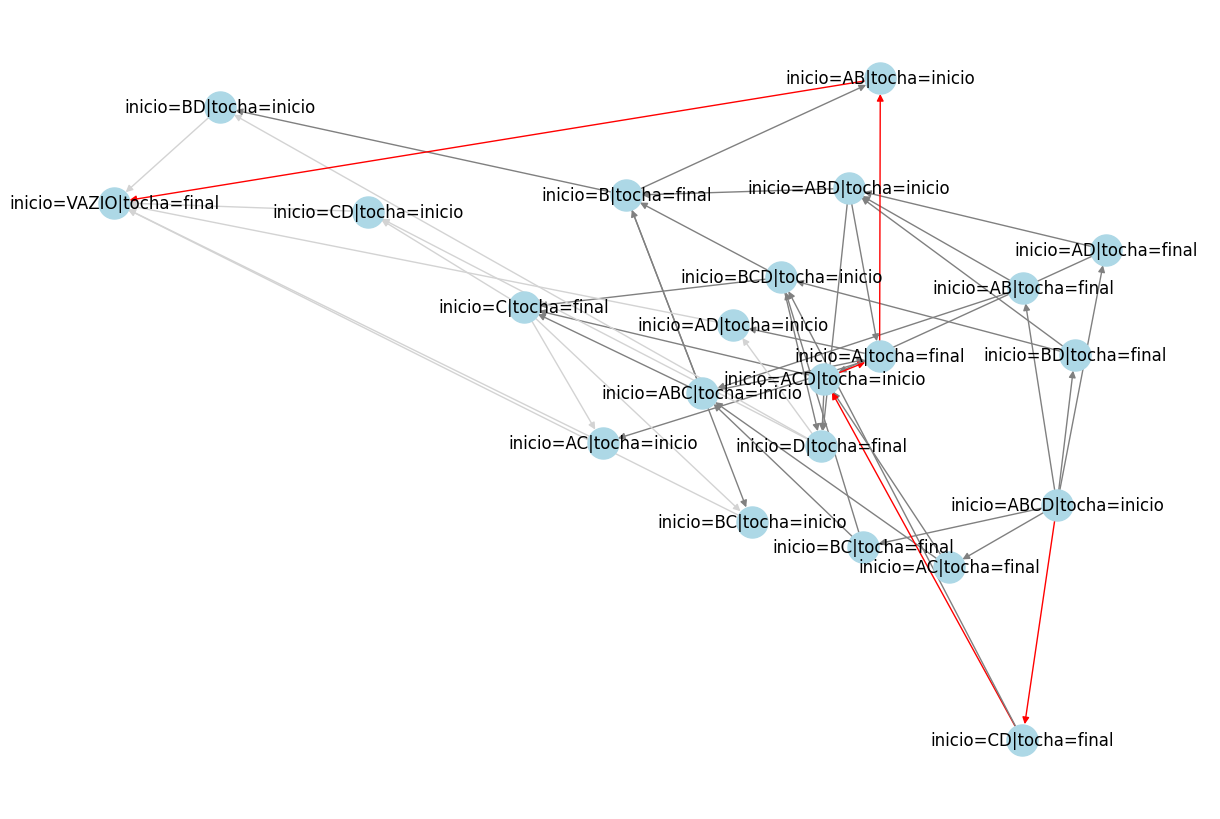

In [28]:
def visualize_exploration(graph, explored_edges, final_path):
    edge_colors = []
    path_edges = set(zip(final_path, final_path[1:]))

    for u, v in graph.edges():
        if (u, v) in path_edges:
            edge_colors.append("red")
        elif (u, v) in explored_edges:
            edge_colors.append("gray")
        else:
            edge_colors.append("lightgray")

    pos = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=500,
            node_color="lightblue", edge_color=edge_colors, arrows=True)
    plt.show()

# Exemplo:
visualize_exploration(main_graph, explored_edges, final_path)